In [1]:
import pandas as pd
import re
import unicodedata
import numpy as np

# Charger le fichier Excel
file_path = "Updated Challenge dataset.xlsx"
excel_data = pd.ExcelFile(file_path)

# Lire les feuilles de données
data = excel_data.parse("Candidat au don 2019 (avec anne")
data2020 = excel_data.parse("Donneurs 2019")

# Fonction pour nettoyer les noms de colonnes (sans changer la casse)
def clean_column_name(col_name):
    col_name = col_name.replace(" ", "_")  # Remplacer les espaces par _
    col_name = col_name.replace("'", "_")  # Remplacer les apostrophes par _
    return col_name

# Appliquer le nettoyage des noms de colonnes
data.columns = [clean_column_name(col) for col in data.columns]
data2020.columns = [clean_column_name(col) for col in data2020.columns]

In [2]:
data2020["Groupe_Sanguin_ABO_/_Rhesus_"]

0       B+
1       O+
2       A+
3       O+
4       O+
        ..
1895    O-
1896    O-
1897    A+
1898    O+
1899    O+
Name: Groupe_Sanguin_ABO_/_Rhesus_, Length: 1900, dtype: object

In [3]:
data2020.columns

Index(['Horodateur', 'Sexe', 'Age_', 'Type_de_donation_',
       'Groupe_Sanguin_ABO_/_Rhesus_', 'Phenotype_'],
      dtype='object')

In [4]:
# Fonction pour nettoyer les valeurs : mettre en minuscules et supprimer la ponctuation
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convertir en minuscules
        text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')  # Supprimer accents
        text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    return text

# Appliquer le nettoyage des valeurs à toutes les colonnes sauf "Groupe Sanguin ABO / Rhesus"
columns_to_clean = [col for col in data.columns if col != "Groupe_Sanguin_ABO_/_Rhesus_"]

for col in columns_to_clean:
    data[col] = data[col].apply(clean_text)




# Appliquer le nettoyage uniquement aux colonnes de type 'object' (string)
data[data.select_dtypes(include=['object']).columns] = data.select_dtypes(include=['object']).map(clean_text)


# Convertir les dates en datetime et gérer les erreurs
data['Date_de_remplissage_de_la_fiche'] = pd.to_datetime(data['Date_de_remplissage_de_la_fiche'], format='%d/%m/%Y', errors='coerce')

data['Date_de_naissance'] = pd.to_datetime(data['Date_de_naissance'], format='%d/%m/%Y', errors='coerce')

# Supprimer les patients nés après 2019 (valeurs aberrantes)
data = data[data['Date_de_naissance'].dt.year <= 2019]



# Convertir l'âge en entier
data['Age'] = pd.to_numeric(2025 - data['Date_de_naissance'].dt.year, errors='coerce').astype('Int64')

In [5]:
data2020["Groupe_Sanguin_ABO_/_Rhesus_"]

0       B+
1       O+
2       A+
3       O+
4       O+
        ..
1895    O-
1896    O-
1897    A+
1898    O+
1899    O+
Name: Groupe_Sanguin_ABO_/_Rhesus_, Length: 1900, dtype: object

In [6]:
# Vérifier si la colonne existe
if 'Taux_d’hémoglobine' in data.columns:
    
    # Fonction de nettoyage pour les strings
    def clean_hemoglobin(value):
        if isinstance(value, str):  # Vérifier si c'est une string
            value = value.replace(',', '.')  # Remplacer les virgules par des points
            value = value.lower().replace('g/dl', '').replace('gdl', 'l').strip()  # Supprimer les unités
            
            try:
                return float(value) / 10  # Convertir en float et diviser par 10
            except ValueError:
                return np.nan  # Mettre NaN si la conversion échoue
        
        return value  # Garder les floats intacts

    # Appliquer le nettoyage sur les strings uniquement
    data['Taux_d’hémoglobine'] = data['Taux_d’hémoglobine'].apply(clean_hemoglobin)


In [7]:

data.rename(columns={'Taux_d’hémoglobine': 'Taux_d’hémoglobine(g/dl)'}, inplace=True)

# Transformer les valeurs en dessous de 0 et au-dessus de 20 en NaN
data['Taux_d’hémoglobine(g/dl)'] = data['Taux_d’hémoglobine(g/dl)'].apply(
    lambda x: x if 0 <= x <= 20 else np.nan
)

# Remplacer la valeur minimale par NaN
valeur_min = data['Taux_d’hémoglobine(g/dl)'].min()
data['Taux_d’hémoglobine(g/dl)'] = data['Taux_d’hémoglobine(g/dl)'].apply(lambda x: np.nan if x == valeur_min else x)

# Vérifier les résultats
print(data['Taux_d’hémoglobine(g/dl)'].describe())


count    1005.000000
mean       13.672139
std         1.518610
min         5.500000
25%        13.000000
50%        13.700000
75%        14.600000
max        20.000000
Name: Taux_d’hémoglobine(g/dl), dtype: float64


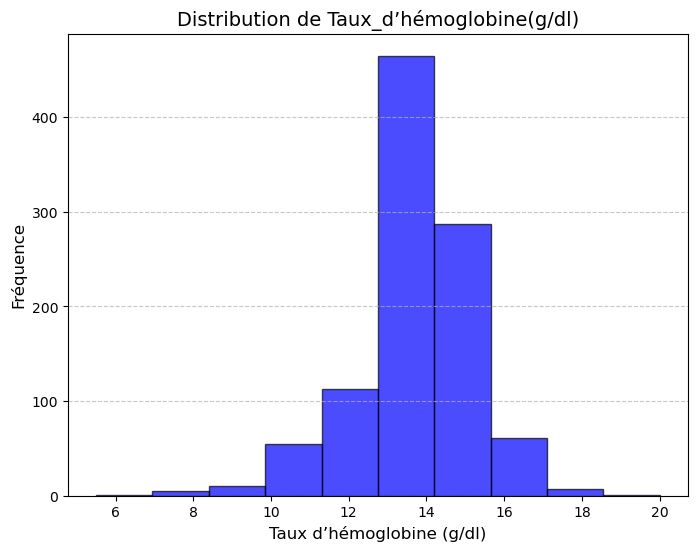

In [15]:
import matplotlib.pyplot as plt

# Vérifier si la colonne existe et contient des valeurs non-NaN
if 'Taux_d’hémoglobine(g/dl)' in data.columns:
    # Créer l'histogramme
    plt.figure(figsize=(8, 6))
    plt.hist(data['Taux_d’hémoglobine(g/dl)'].dropna(), bins=10, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Distribution de Taux_d’hémoglobine(g/dl)', fontsize=14)
    plt.xlabel('Taux d’hémoglobine (g/dl)', fontsize=12)
    plt.ylabel('Fréquence', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [17]:
# Supprimer les patients collectés hors de 2019
data = data[data['Date_de_remplissage_de_la_fiche'].dt.year == 2019]

# Transformer 'Type de donation' dans data2020
if 'Type_de_donation' in data2020.columns:
    data2020['Type_de_donation'] = data2020['Type_de_donation'].replace({'F': 'Familiale', 'B': 'Benevole'})


In [19]:
# Étape 2 : Regroupement intelligent des professions
category_mapping = {
    # Agriculture & Environnement
    'agriculteur': 'agriculture & environnement',
    'technicien en agriculture': 'agriculture & environnement',
    'ingénieur agronome': 'agriculture & environnement',
    'conseiller agropastoral': 'agriculture & environnement',
    'planteur': 'agriculture & environnement',
    'forestier': 'agriculture & environnement',
    'cultivateur ': 'agriculture & environnement',
    'Technicien supérieur d’agriculture': 'agriculture & environnement',
    'cultivateur': 'agriculture & environnement',
    'planteur': 'agriculture & environnement',
    'forestier': 'agriculture & environnement',
    'technicien superieur dagriculture': 'agriculture & environnement',
    'ingenieur agronome': 'agriculture & environnement',
    'maitre pecheur': 'agriculture & environnement',

    # Bâtiment & Travaux Publics (BTP)
    'maçon': 'bâtiment & travaux publics (btp)',
    'carreleur': 'bâtiment & travaux publics (btp)',
    'peintre': 'bâtiment & travaux publics (btp)',
    'staffeur': 'bâtiment & travaux publics (btp)',
    'technicien en bâtiment': 'bâtiment & travaux publics (btp)',
    'géomètre': 'bâtiment & travaux publics (btp)',
    'conducteur d\'engins': 'bâtiment & travaux publics (btp)',
    'constructeur en bâtiment': 'bâtiment & travaux publics (btp)',
    'ingénieur génie civil': 'bâtiment & travaux publics (btp)',
    'technicien génie civil': 'bâtiment & travaux publics (btp)',
    'Ingenieur': 'bâtiment & travaux publics (btp)',
    'maçon': 'bâtiment & travaux publics (btp)',
    'carreleur': 'bâtiment & travaux publics (btp)',
    'peintre': 'bâtiment & travaux publics (btp)',
    'staffeur': 'bâtiment & travaux publics (btp)',
    'technicien en bâtiment': 'bâtiment & travaux publics (btp)',
    'géomètre': 'bâtiment & travaux publics (btp)',
    'conducteur d\'engins': 'bâtiment & travaux publics (btp)',
    'constructeur en bâtiment': 'bâtiment & travaux publics (btp)',
    'ingénieur génie civil': 'bâtiment & travaux publics (btp)',
    'technicien génie civil': 'bâtiment & travaux publics (btp)',
    'technicien en génie civil': 'bâtiment & travaux publics (btp)',
    'technicien topo': 'bâtiment & travaux publics (btp)',
    'dessinateur': 'bâtiment & travaux publics (btp)',
    'macon': 'Bâtiment & Travaux Publics (BTP)',
    'plombier': 'Bâtiment & Travaux Publics (BTP)',
    'electricien en batiment': 'Bâtiment & Travaux Publics (BTP)',
    'conducteur de travaux genie civil': 'Bâtiment & Travaux Publics (BTP)',
    'electricien ': 'btp & industrie',
    'cableur': 'btp & industrie',
    'agent de maintenance indusyrielle': 'btp & industrie',
    'mecanicien': 'btp & industrie',
    'technicien du genie sanitaire': 'btp & industrie',
    'industrie & production': 'btp & industrie',
    'agent dexploitation': 'btp & industrie',
    'ingenieur genie civil': 'btp & industrie',
    'technicien de genie civile': 'btp & industrie',
    'chaudronier': 'btp & industrie',
    'electricien plombier': 'btp & industrie',
    'menuisier ': 'btp & industrie',
    'electricien en batiment ': 'btp & industrie',
    'ingenieur civil ': 'btp & industrie',
    'mecanicien ': 'btp & industrie',
    'electrotechnicien ': 'btp & industrie',
    'ingenieur en mecanique ': 'btp & industrie',
    'constructeur en batiment': 'btp & industrie',
    'conducteurs dengins genie civil': 'btp & industrie',
    'technicien en batiment ': 'btp & industrie',
    'technicien en genie civil': 'btp & industrie',
    'genie civil': 'btp & industrie',
    'technicien aeronautique': 'btp & industrie',
    'geometre': 'btp & industrie',
    'architecte': 'btp & industrie',
    'controleur qualite': 'btp & industrie',

    # Commerce & Vente
    'commerçant': 'commerce & vente',
    'vendeur': 'commerce & vente',
    'vendeuse': 'commerce & vente',
    'agent commercial': 'commerce & vente',
    'marchand': 'commerce & vente',
    'business man': 'commerce & vente',
    'commercial': 'commerce & vente',
    'responsable commercial': 'commerce & vente',
    'acheteur logisticien': 'commerce & vente',
    'trader': 'commerce & vente',
    'trader indep': 'commerce & vente',
    'commercant e': 'commerce & vente',
    'vendeur': 'commerce & vente',
    'commercial': 'commerce & vente',
    'agent commercial': 'commerce & vente',
     'agent commercial ': 'commerce & vente',
    'vendeur ': 'commerce & vente',
    'commerciale ': 'commerce & vente',
    'cadre commercial': 'commerce & vente',
    'commercialdistributeur': 'commerce & vente',

    # Finance & Comptabilité
    'comptable': 'finance & comptabilité',
    'chef comptable': 'finance & comptabilité',
    'auditeur interne': 'finance & comptabilité',
    'gestionnaire': 'finance & comptabilité',
    'fiscaliste': 'finance & comptabilité',
    'financier': 'finance & comptabilité',
    'aide comptable': 'finance & comptabilité',
    'agent de banque': 'finance & comptabilité',
    'comptable financier': 'finance & comptabilité',
    'auditeur comptable': 'finance & comptabilité',
    'gestionnaire de ressources humaines': 'finance & comptabilité',
    'comptable': 'finance & comptabilité',
    'audit comptable': 'finance & comptabilité',
    'banquier': 'finance & comptabilité',

    # Hôtellerie & Restauration
    'hôtelier': 'hôtellerie & restauration',
    'réceptionniste': 'hôtellerie & restauration',
    'restaurateur': 'hôtellerie & restauration',
    'pâtissier': 'hôtellerie & restauration',
    'cuisinier': 'hôtellerie & restauration',
    'brasseur': 'hôtellerie & restauration',
    'gouvernant d\'hôtel': 'hôtellerie & restauration',
    'boulanger': 'hôtellerie & restauration',
    'caissiere': 'hôtellerie & restauration',
    'hotelier': 'hôtellerie & restauration',
    'restaurateur': 'hôtellerie & restauration',
    'hôtellerie & restauration': 'hôtellerie & restauration',
    'hotellier': 'hôtellerie & restauration',
    'patissier': 'hôtellerie & restauration',
    'hoteliere': 'hôtellerie & restauration',
    'comis de salle': 'hôtellerie & restauration',
    'receptioniste caissiere': 'hôtellerie & restauration',
    'boulanger': 'hôtellerie & restauration',

    # Sécurité & Défense
    'agent de sécurité': 'sécurité & défense',
    'vigile': 'sécurité & défense',
    'militaire': 'sécurité & défense',
    'gendarme': 'sécurité & défense',
    'chef de sécurité': 'sécurité & défense',
    'brancardier': 'sécurité & défense',
    'agent municipal': 'sécurité & défense',
    'douanier': 'sécurité & défense',
    'pointeur': 'sécurité & défense',
    'agent de sécurite': 'sécurité & défense',
    'security officer': 'sécurité & défense',
    'technicien de securite': 'sécurité & défense',
    'angent de securite': 'sécurité & défense',
    'marin': 'sécurité & défense',
    'agent communal': 'sécurité & défense',
    'agent fret airport': 'sécurité & défense',
    'contrôleur des douanes': 'sécurité & défense',
    'agent d\'exploitation': 'sécurité & défense',
    'agent de securite': 'sécurité & défense',
    'vigil': 'sécurité & défense',
    'militaire': 'sécurité & défense',
    'chef de securite': 'sécurité & défense',
    'agent de securite ': 'sécurité & défense',
    'agent de securite hgoped': 'sécurité & défense',
    'charger de la securite': 'sécurité & défense',
    'argent de securite ': 'sécurité & défense',
    'fonctionnaires': 'sécurité & défense',

    # Transport & Logistique
    'chauffeur': 'transport & logistique',
    'taximan': 'transport & logistique',
    'transporteur': 'transport & logistique',
    'agent maritime': 'transport & logistique',
    'gestionnaire de vols': 'transport & logistique',
    'mototaximan': 'transport & logistique',
    'chauffeur': 'transport & logistique',
    'mototaximan': 'transport & logistique',
    'moto-taximan': 'transport & logistique',
    'moto taximan': 'transport & logistique',
    'motoman': 'transport & logistique',
    'conducteur': 'transport & logistique',
    'taximan': 'transport & logistique',
    'docker': 'transport & logistique',
    'agent portuaire': 'transport & logistique',
    'opérateur portique': 'transport & logistique',
    'chauffeur': 'transport & logistique',
    'conducteur dengin': 'transport & logistique',
    'logisticien': 'transport & logistique',
    'chauffeur ': 'transport & logistique',
    'agent fret airport ': 'transport & logistique',
    'conducteur engin ': 'transport & logistique',
    'transport & logistique': 'transport & logistique',
    'responsable transport': 'transport & logistique',

    # Art & Communication
    'musicien': 'art & communication',
    'chantre musicien': 'art & communication',
    'chargée de communication': 'art & communication',
    'communicateur': 'art & communication',
    'artiste': 'art & communication',
    'artisant': 'art & communication',
    'graphiste': 'art & communication',
    'sérigraphe': 'art & communication',
    'photographe': 'art & communication',
    'réalisateur': 'art & communication',
    'infographe': 'art & communication',
    'designer': 'art & communication',
    'styliste': 'art & communication',
    'publicitaire': 'art & communication',
    'peintre': 'art & communication',
    'realisateur': 'Art & Communication',
    'chargee de communication': 'Art & Communication',
    'journaliste': 'Art & Communication',

    # Informatique & Télécommunications
    'informaticien': 'informatique & télécommunications',
    'ingénieur logiciel': 'informatique & télécommunications',
    'développeur en informatique': 'informatique & télécommunications',
    'analyste-programmeur': 'informatique & télécommunications',
    'technicien réseaux et télécoms': 'informatique & télécommunications',
    'informatitien': 'informatique & télécommunications',
    'developpeur en informatique': 'informatique & télécommunications',
    'analyste programmeur': 'informatique & télécommunications',

    # Industrie & Production
    'soudeur': 'industrie & production',
    'chaudronnier': 'industrie & production',
    'électricien': 'industrie & production',
    'mécanicien': 'industrie & production',
    'tôlier': 'industrie & production',
    'ferronnier': 'industrie & production',
    'électronicien': 'industrie & production',
    'ingénieur mécanique': 'industrie & production',
    'ingénieur industriel': 'industrie & production',
    'technicien en métallurgie': 'industrie & production',
    'électrotechnicien': 'industrie & production',
    'électronicien': 'industrie & production',
     'electronicien': 'industrie & production',
    'electrotechnicien': 'industrie & production',
    'technicien en metallurgie': 'industrie & production',

    # Santé & Paramédical
    'médecin': 'santé & paramédical',
    'infirmier': 'santé & paramédical',
    'technicien de laboratoire': 'santé & paramédical',
    'pharmacien': 'santé & paramédical',
    'auxiliaire de pharmacie': 'santé & paramédical',
    'personnel de sante': 'santé & paramédical',
    'chirurgien-dentiste': 'santé & paramédical',
    'medecin': 'santé & paramédical',
    'ingenieur biologiste': 'santé & paramédical',
    'Technicien de laboratoire': 'santé & paramédical',
    'Laborantin': 'santé & paramédical',
    'atms': 'santé & paramédical',
    'medecin': 'santé & paramédical',
    'infirmier': 'santé & paramédical',
    'pharmacien': 'santé & paramédical',
    'intendant infirmier superieur ': 'santé & paramédical',
    'santé & paramédical': 'santé & paramédical',
    'medecin ': 'santé & paramédical',
    'laborantin': 'santé & paramédical',
    'aide chirugien': 'santé & paramédical',
    'delegue medical': 'santé & paramédical',
    'ide urgentiste': 'santé & paramédical',
    'chirurgienne dentiste': 'santé & paramédical',
    'veterinaire': 'santé & paramédical',

    # Administration & Gestion
    'secrétaire': 'administration & gestion',
    'assistant administratif': 'administration & gestion',
    'intendant': 'administration & gestion',
    'administrateur': 'administration & gestion',
    'chargé de clientèle': 'administration & gestion',
    'directeur général': 'administration & gestion',
    'agent administratif': 'administration & gestion',
    'directeur general': 'administration & gestion',
    'assistant administratif': 'administration & gestion',
    'assistant dadministratif': 'administration & gestion',
    'gestionnaire ressources humaines': 'administration & gestion',
    'manager administratif': 'administration & gestion',
    'administration & gestion': 'administration & gestion',
    'assistant rh': 'administration & gestion',
    'agent des ressourses humaines': 'administration & gestion',
    'cadre contractuel': 'administration & gestion',
    

    # Éducation & Formation
    'enseignant': 'éducation & formation',
    'éducateur': 'éducation & formation',
    'formateur': 'éducation & formation',
    'assistant pédagogique': 'éducation & formation',
    'pleg': 'éducation & formation',
    'maitresse': 'éducation & formation',
    'enseignant e': 'éducation & formation',
     'enseignant': 'éducation & formation',
    'professeur': 'éducation & formation',

    # Travail Manuel & Artisanat
    'menuisier': 'travail manuel & artisanat',
    'couturier': 'travail manuel & artisanat',
    'bijoutier': 'travail manuel & artisanat',
    'ébéniste': 'travail manuel & artisanat',
    'cordonnier': 'travail manuel & artisanat',
    'sculpteur': 'travail manuel & artisanat',
    'tapissier': 'travail manuel & artisanat',
    'mécanicien': 'travail manuel & artisanat',
    'tapissier': 'travail manuel & artisanat',
    'électricien ': 'travail manuel & artisanat',
    'technicien': 'travail manuel & artisanat',
    'soudeur': 'travail manuel & artisanat',
    'coiffeur': 'travail manuel & artisanat',
    'coiffeuse': 'travail manuel & artisanat',
    'sportifs': 'travail manuel & artisanat',
    'machiniste': 'travail manuel & artisanat',
    'menuisier': 'travail manuel & artisanat',
    'couturiere': 'travail manuel & artisanat',

    # Services & Assistance
    'agent d\'entretien': 'services & assistance',
    'femme au foyer': 'services & assistance',
    'coiffeur': 'services & assistance',
    'esthéticienne': 'services & assistance',
    'technicienne de surface': 'services & assistance',
    'ménagère': 'services & assistance',
    'menagere': 'services & assistance',
    'cuisinier': 'services & assistance',
    'agent d\'entretien': 'services & assistance',
    'Service d\'entretien': 'services & assistance',
    'conseille technique ': 'services & assistance',
    'agent dappui': 'services & assistance',
    'agent de proprete': 'services & assistance',

    # Élèves & Étudiants
    'élève': 'étudiants et élèves',
    'élève': 'étudiants et élèves',
    'eleve': 'étudiants et élèves',
    'etudiant': 'étudiants et élèves',
    'etudiant (e)': 'étudiants et élèves',
    'étudiant': 'étudiants et élèves',
    'etudiant e': 'étudiants et élèves',
    'eleve ': 'étudiants et élèves',
    'etudiant': 'étudiants et élèves',
    'stagiaire': 'étudiants et élèves',

   # Informatique & Télécommunications
    'informaticien': 'informatique & télécommunications',
    'infographe': 'informatique & télécommunications',
    'business development': 'informatique & télécommunications',
    'developpeur en informatique': 'informatique & télécommunications',
    'informaticien de reseau': 'informatique & télécommunications',
    'informatien': 'informatique & télécommunications',
    'informatticien': 'informatique & télécommunications',
    'ingenieur des telecommunications': 'informatique & télécommunications',
    'ingenieur en informatique': 'informatique & télécommunications',
    'ingenieur logiciel': 'informatique & télécommunications',
    'ingenieur reseaux et telecom': 'informatique & télécommunications',
    'ingenieur reseaux telecoms': 'informatique & télécommunications',
    'market developper': 'informatique & télécommunications',
    'technicien telecom': 'informatique & télécommunications',
    'developpeur en informatique ': 'informatique & télécommunications',
    'informaticien ': 'informatique & télécommunications',
    'reseaux et telecommunications ': 'informatique & télécommunications',
    'ingenieur des telecommunications ': 'informatique & télécommunications',
    'ingenieur biotechnologie': 'informatique & télécommunications',
    'ingenieur en bateau': 'informatique & télécommunications',
    'technicien en froid et climatisation': 'informatique & télécommunications',

    # Sans Emploi & Divers
    'sans emploi': 'Sans Emploi & Divers',
    'pas précisé': 'Sans Emploi & Divers',
    'débrouillard': 'Sans Emploi & Divers',
    'femme au foyer': 'sSans Emploi & Divers',
    'ras': 'sans emploi',
    'sans emplois': 'Sans Emploi & Divers',
    'chomeur': 'Sans Emploi & Divers',
    'pas precise': 'Sans Emploi & Divers',
    'sans emploi ': 'Sans Emploi & Divers',
    'pas precisee': 'Sans Emploi & Divers',
    'pas mentionne': 'Sans Emploi & Divers',
    'homme a tout faire': 'Sans Emploi & Divers',
    'debrouillard': 'Sans Emploi & Divers',
    
     # Fonction Publique & Institutions
    'fonctionnaire': 'Fonction Publique & Institutions',
    'administrateur des hopitaux': 'Fonction Publique & Institutions',

    # Énergie & Environnement
    'energeticien': 'Fonction Publique & Institutions',
    
}

# Si la valeur n'est pas dans le mapping, garder la valeur originale
data['Profession'] = data['Profession'].map(category_mapping).fillna(data['Profession'])

In [21]:
data['Profession'].value_counts()

Profession
étudiants et élèves            359
Sans Emploi & Divers           235
commerce & vente               136
transport & logistique         120
btp & industrie                105
                              ... 
mecatronicien nta                1
assistant transit                1
technicien superieur             1
technicien en batiment           1
electricien instrumentiste       1
Name: count, Length: 227, dtype: int64

In [23]:
# Identifier les colonnes correspondant au motif de raisons
colonnes_cible = [col for col in data.columns if col.startswith("Raison")]

# Remplacer les valeurs vides par "Non" dans les colonnes ciblées
data[colonnes_cible] = data[colonnes_cible].fillna("Non")  
data[colonnes_cible] = data[colonnes_cible].replace("", "Non")  


In [25]:
print(data[(data['Genre'] == 'femme') & (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'oui')].head(10))

     Date_de_remplissage_de_la_fiche Date_de_naissance Niveau_d_etude  Genre  \
1233                      2019-10-17        1984-10-18     secondaire  femme   
1247                      2019-10-21        1978-03-10       primaire  femme   
1356                      2019-11-12        1995-05-23  universitaire  femme   
1369                      2019-11-12        1995-05-23  universitaire  femme   
1370                      2019-11-12        1986-10-05  universitaire  femme   
1371                      2019-11-12        1987-02-25     secondaire  femme   
1410                      2019-11-22        1994-04-27  universitaire  femme   
1417                      2019-11-25        1999-03-21     secondaire  femme   
1677                      2019-06-20        1981-06-25     secondaire  femme   
1678                      2019-06-20        1986-04-08     secondaire  femme   

      Taille  Poids Situation_Matrimoniale_(SM)                  Profession  \
1233   162.0   85.0                 celi

In [27]:
# Vérifier les données correspondant aux conditions
femmes_oui = data.loc[
    (data['Genre'] == 'femme') & (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'oui'),
    'Taux_d’hémoglobine(g/dl)'
]

print(femmes_oui)


1233    11.6
1247    10.9
1356    11.2
1369    11.2
1370    10.6
1371    11.2
1410    11.4
1417    10.0
1677    10.5
1678    11.6
1679     9.7
1681    11.2
1684    10.8
1686    11.1
1687    10.8
1689     9.0
1690     7.5
1696     8.1
1697    10.1
1698    10.4
1699    11.5
1701     7.0
1702    10.8
1706     7.4
1725    11.5
1763    11.2
1765    10.6
1768    10.6
1781    11.6
1816     9.8
1825    11.5
1831    11.3
1836    10.1
1842     9.4
1862    12.6
1877    11.3
1891     5.5
1902     NaN
1903     NaN
Name: Taux_d’hémoglobine(g/dl), dtype: float64


In [29]:
# Corriger les erreurs d'orthographe dans la colonne
data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] = data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'].str.lower()


# Step 1: Replace values > 20 with NaN
data['Taux_d’hémoglobine(g/dl)'] = data['Taux_d’hémoglobine(g/dl)'].apply(lambda x: x if x <= 20 else None)

moyenne_femmes_oui = data.loc[
    (data['Genre'] == 'femme') & (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'oui'),
    'Taux_d’hémoglobine(g/dl)'
].mean()

# 2️ Moyenne pour les femmes avec "non"
moyenne_femmes_non = data.loc[
    (data['Genre'] == 'femme') & (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'non'),
    'Taux_d’hémoglobine(g/dl)'
].mean()

# 3️ Moyenne pour les hommes avec "oui"
moyenne_hommes_oui = data.loc[
    (data['Genre'] == 'homme') & (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'oui'),
    'Taux_d’hémoglobine(g/dl)'
].mean()

# 4️ Moyenne pour les hommes avec "non"
moyenne_hommes_non = data.loc[
    (data['Genre'] == 'homme') & (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'non'),
    'Taux_d’hémoglobine(g/dl)'
].mean()

#  Remplacement des valeurs manquantes
data.loc[
    (data['Genre'] == 'femme') & 
    (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'oui') & 
    (data['Taux_d’hémoglobine(g/dl)'].isna()), 
    'Taux_d’hémoglobine(g/dl)'
] = moyenne_femmes_oui

data.loc[
    (data['Genre'] == 'femme') & 
    (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'non') & 
    (data['Taux_d’hémoglobine(g/dl)'].isna()), 
    'Taux_d’hémoglobine(g/dl)'
] = moyenne_femmes_non

data.loc[
    (data['Genre'] == 'homme') & 
    (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'oui') & 
    (data['Taux_d’hémoglobine(g/dl)'].isna()), 
    'Taux_d’hémoglobine(g/dl)'
] = moyenne_hommes_oui

data.loc[
    (data['Genre'] == 'homme') & 
    (data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'] == 'non') & 
    (data['Taux_d’hémoglobine(g/dl)'].isna()), 
    'Taux_d’hémoglobine(g/dl)'
] = moyenne_hommes_non

#  Vérification des moyennes utilisées
print(f"Moyenne Femme - Oui : {moyenne_femmes_oui:.2f}")
print(f"Moyenne Femme - Non : {moyenne_femmes_non:.2f}")
print(f"Moyenne Homme - Oui : {moyenne_hommes_oui:.2f}")
print(f"Moyenne Homme - Non : {moyenne_hommes_non:.2f}")

#  Vérification de quelques lignes après imputation
print(data[['Genre', 'Raison_indisponibilité__[Taux_d’hémoglobine_bas_]', 'Taux_d’hémoglobine(g/dl)']].head(10))

print(data['Genre'].unique())  
print(data['Raison_indisponibilité__[Taux_d’hémoglobine_bas_]'].unique()) 


Moyenne Femme - Oui : 10.34
Moyenne Femme - Non : 12.87
Moyenne Homme - Oui : 11.24
Moyenne Homme - Non : 14.11
    Genre Raison_indisponibilité__[Taux_d’hémoglobine_bas_]  \
15  homme                                               non   
16  homme                                               non   
17  homme                                               non   
18  homme                                               non   
19  homme                                               non   
20  homme                                               non   
21  homme                                               non   
22  homme                                               non   
23  homme                                               non   
24  homme                                               non   

    Taux_d’hémoglobine(g/dl)  
15                      16.1  
16                      13.0  
17                      14.3  
18                      14.6  
19                      15.4  
20      

In [31]:
#  Vérification de quelques lignes après imputation
data['Genre'].value_counts()




Genre
homme    1660
femme     179
Name: count, dtype: int64

In [33]:
# Sauvegarder les fichiers nettoyés avec un séparateur compatible Excel (version FR)
data.to_csv("Candidat_au_don_2019_cleaned.csv", index=False, sep=';')
data2020.to_csv("Donneurs_2019_cleaned.csv", index=False, sep=';')

